# Assessment of Land Surface Temperature (LST) Trend in Kano Municipal

In [1]:
# data wrangling libraries
import pandas as pd
import numpy as np
import os
# geospatial libraries
import ee
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import Image
import geemap
import seaborn as sns
import rasterio
from rasterio.plot import show
from rasterio.transform import rowcol

import glob

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize


# statistics libraries
import pymannkendall as mk
from scipy import stats
import pyhomogeneity as ph
from sklearn.linear_model import QuantileRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# authenticate and initialize ee
ee.Authenticate()
ee.Initialize(project='ld-slm')

In [4]:
# Retrieve Kano districts from Google Earth Engine's public datasets
studyArea = (
    ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")
    .filter(
        ee.Filter.Or(
            ee.Filter.equals("ADM2_NAME", "Kano Municipal"),
            ee.Filter.equals("ADM2_NAME", "Kumbotso"),
            ee.Filter.equals("ADM2_NAME", "Tarauni"),
            ee.Filter.equals("ADM2_NAME", "Gwale")
        )
    )
)

studyArea = studyArea.geometry().dissolve()

In [5]:
kanoMunicipal = ee.data.listFeatures({
    'assetId': 'FAO/GAUL_SIMPLIFIED_500m/2015/level2',
    'region': studyArea.getInfo(),
    # 'filter': 'ADM2_NAME == Kano Municipal',
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

studyAreadf = kanoMunicipal[kanoMunicipal['ADM2_NAME'].isin(['Kano Municipal', 'Kumbotso', 'Tarauni', 'Gwale'])]
studyAreadf = studyAreadf.dissolve(by='ADM1_NAME')
studyAreadf.set_crs(epsg=4326, inplace=True)
studyAreadf.to_file('data/study_area.shp')

In [6]:
# View it in geemap
m = geemap.Map()
m.center_object(studyArea,12)
m.add_layer(studyArea,{},'Kano Municipal')
m

Map(center=[11.920198527905436, 8.495386472422346], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Retrieve the land cover for the study area

lu = ee.ImageCollection("ESA/WorldCover/v100").first().clip(studyArea)

geemap.ee_export_image(lu.clip(studyArea), scale=10,region=studyArea, filename='data/Kano Municipal Land Cover.tif')

Generating URL ...
Please wait ...
Data downloaded to C:\Users\DELL\Downloads\RS&GIS_Stuff\LST Trend\data\Kano Municipal Land Cover.tif


In [7]:
# Create a dry season filter
dryFilter = ee.Filter.dayOfYear(294,100)
water = (
    ee.Image('JRC/GSW1_0/GlobalSurfaceWater')
    .select( 'occurrence')
)

notWater = water.mask().Not()

In [8]:
# Retrive Landsat 8 image from 2013 to 2024
landsat8 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
    .filterDate('2013','2025')
    .filter(dryFilter)
    .filterBounds(studyArea)
    .filter(ee.Filter.lessThanOrEquals('CLOUD_COVER',4))
)
m.add_layer(landsat8.first(),{}, 'Landsat 8')
m

Map(bottom=489615.0, center=[11.920198527905436, 8.495386472422346], controls=(WidgetControl(options=['positio…

In [9]:
# NDVI Calculation
def ndvi(image):
    ndvi = (
        image.normalizedDifference(["B5","B4"])
        .rename("NDVI")
        .clip(studyArea)
    )
    return ndvi

## Land Surface Temperature Calculation

In [10]:
def calculateLST(image):
    a = ee.Number(0.004)
    b = ee.Number(0.986)
    
    # Select thermal band
    thermal = image.select('B10').updateMask(notWater)
    
    # NDVI Calculation using expression
    NDVI = image.expression(
        '(band5 - band4) / (band5 + band4)',
        {'band5': image.select('B5'), 'band4': image.select('B4')}
    ).updateMask(notWater).rename('NDVI')
    
    minMax = NDVI.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e9
    )
    
    minValue = ee.Number(minMax.get('NDVI_min'))
    maxValue = ee.Number(minMax.get('NDVI_max'))
    
    pv = NDVI.subtract(minValue).divide(maxValue.subtract(minValue)).pow(ee.Number(2)).rename("PV")
    
    # Emissivity calculation
    em = pv.multiply(a).add(b).rename('LSE')
    
    # Land Surface Temperature (LST) calculation
    lstLandsat = image.expression(
        '(Tb / (1 + (0.001145 * (Tb / 1.438)) * log(EM))) - 273.15', { 
            'Tb': thermal,
            'EM': em
        }
    ).rename('LST')
    
    return image.addBands(lstLandsat)

lstCollection = landsat8.map(calculateLST)

In [11]:
# check the number of images
lstCollection.size().getInfo()

215

In [12]:
# Visualize the first image in the collection
# Get the minimum value of LST from the first image in the collection
lst_image = lstCollection.first()

# Get the minimum value of the LST band
min_value = lst_image.select('LST').reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=lst_image.geometry(),
    scale=30,  # Landsat resolution
    maxPixels=1e9
).get('LST')

# Print the minimum value
print('Minimum LST value:', min_value.getInfo())
max_value = lst_image.select('LST').reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=lst_image.geometry(),
    scale=30,
    maxPixels=1e9
).get('LST')

print('Maximum LST value:', max_value.getInfo())

Minimum LST value: 12.348544054691558
Maximum LST value: 43.08643409848764


In [13]:
lst_viz_params = {
  'bands': ['LST'],
  'min': min_value,
  'max': max_value, 
  'palette': ['blue', 'cyan', 'green', 'yellow', 'red'] 
}

m.add_layer(lstCollection.first().clip(studyArea), lst_viz_params, 'LST')
m

Map(bottom=489615.0, center=[11.920198527905436, 8.495386472422346], controls=(WidgetControl(options=['positio…

In [14]:
out_dir = os.path.join(os.path.expanduser("~"), "Downloads/RS&GIS_Stuff/LST Trend/lst files")

In [15]:
def calculate_yearly_averages(collection, start_year, end_year):
    yearly_averages = []
    
    for year in range(start_year, end_year + 1):
        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"
        
        year_collection = collection.filterDate(start_date, end_date)
        
        # Calculate the mean for the year
        yearly_mean = year_collection.mean()
        
        # Set properties for easier identification
        yearly_mean = yearly_mean.set('year', year)
        yearly_mean = yearly_mean.set('system:time_start', ee.Date(start_date).millis())
        
        # Add to the list
        yearly_averages.append(yearly_mean)
    
    # Convert list to ImageCollection
    yearly_avg_collection = ee.ImageCollection.fromImages(yearly_averages)
    return yearly_avg_collection

# Calculate yearly averages from 2013 to 2024
yearly_averages = calculate_yearly_averages(lstCollection.select('LST'), 2013, 2024)

In [16]:
year_2020 = yearly_averages.first()
m.add_layer(year_2020.clip(studyArea), lst_viz_params, 'Mean LST 2020')

In [17]:
m

Map(bottom=489615.0, center=[11.920198527905436, 8.495386472422346], controls=(WidgetControl(options=['positio…

In [18]:
def export_yearly_averages(yearly_avg_collection, export_folder, region=None, scale=10):
    # Convert the collection to a list
    image_list = yearly_avg_collection.toList(yearly_avg_collection.size())
    count = image_list.size().getInfo()
    
    # Create output directory if it doesn't exist
    if not os.path.exists(export_folder):
        os.makedirs(export_folder)
    
    # Export each yearly average
    for i in range(count):
        image = ee.Image(image_list.get(i))
        year = image.get('year').getInfo()
        filename = os.path.join(export_folder, f'yearly_avg_{year}.tif')
        
        # Use geemap to export the image
        geemap.ee_export_image(
            image, 
            filename=filename, 
            scale=scale, 
            region=region,
            file_per_band=False
        )
        print(f"Exporting yearly average for {year} to {filename}")

In [19]:
# geemap.ee_export_image_collection(yearly_averages, out_dir=out_dir, region=studyArea, file_per_band=False, scale=10)

In [22]:
poi = gpd.read_file('data/poi.shp')
poi

id  SAMPLE_1                  geometry
0  996        50  POINT (8.47564 11.92345)
1    0        30   POINT (8.49175 11.8965)
2  759        40  POINT (8.40619 11.92188)
3  804        20  POINT (8.45962 11.94481)
4  766        10  POINT (8.50506 11.96312)
5  786        60  POINT (8.56978 11.92876)

In [37]:
LandClass = {
    10:"Tree cover",
    20:"Shrubland",
    30:"Grasslanf",
    40:"Cropland",
    50:"Built-up",
    60:"Bareland"
}


poi['landuse'] = poi['SAMPLE_1'].replace(LandClass)
poi

id  SAMPLE_1                  geometry     landuse
0  996        50  POINT (8.47564 11.92345)    Built-up
1    0        30   POINT (8.49175 11.8965)   Grasslanf
2  759        40  POINT (8.40619 11.92188)    Cropland
3  804        20  POINT (8.45962 11.94481)   Shrubland
4  766        10  POINT (8.50506 11.96312)  Tree cover
5  786        60  POINT (8.56978 11.92876)    Bareland

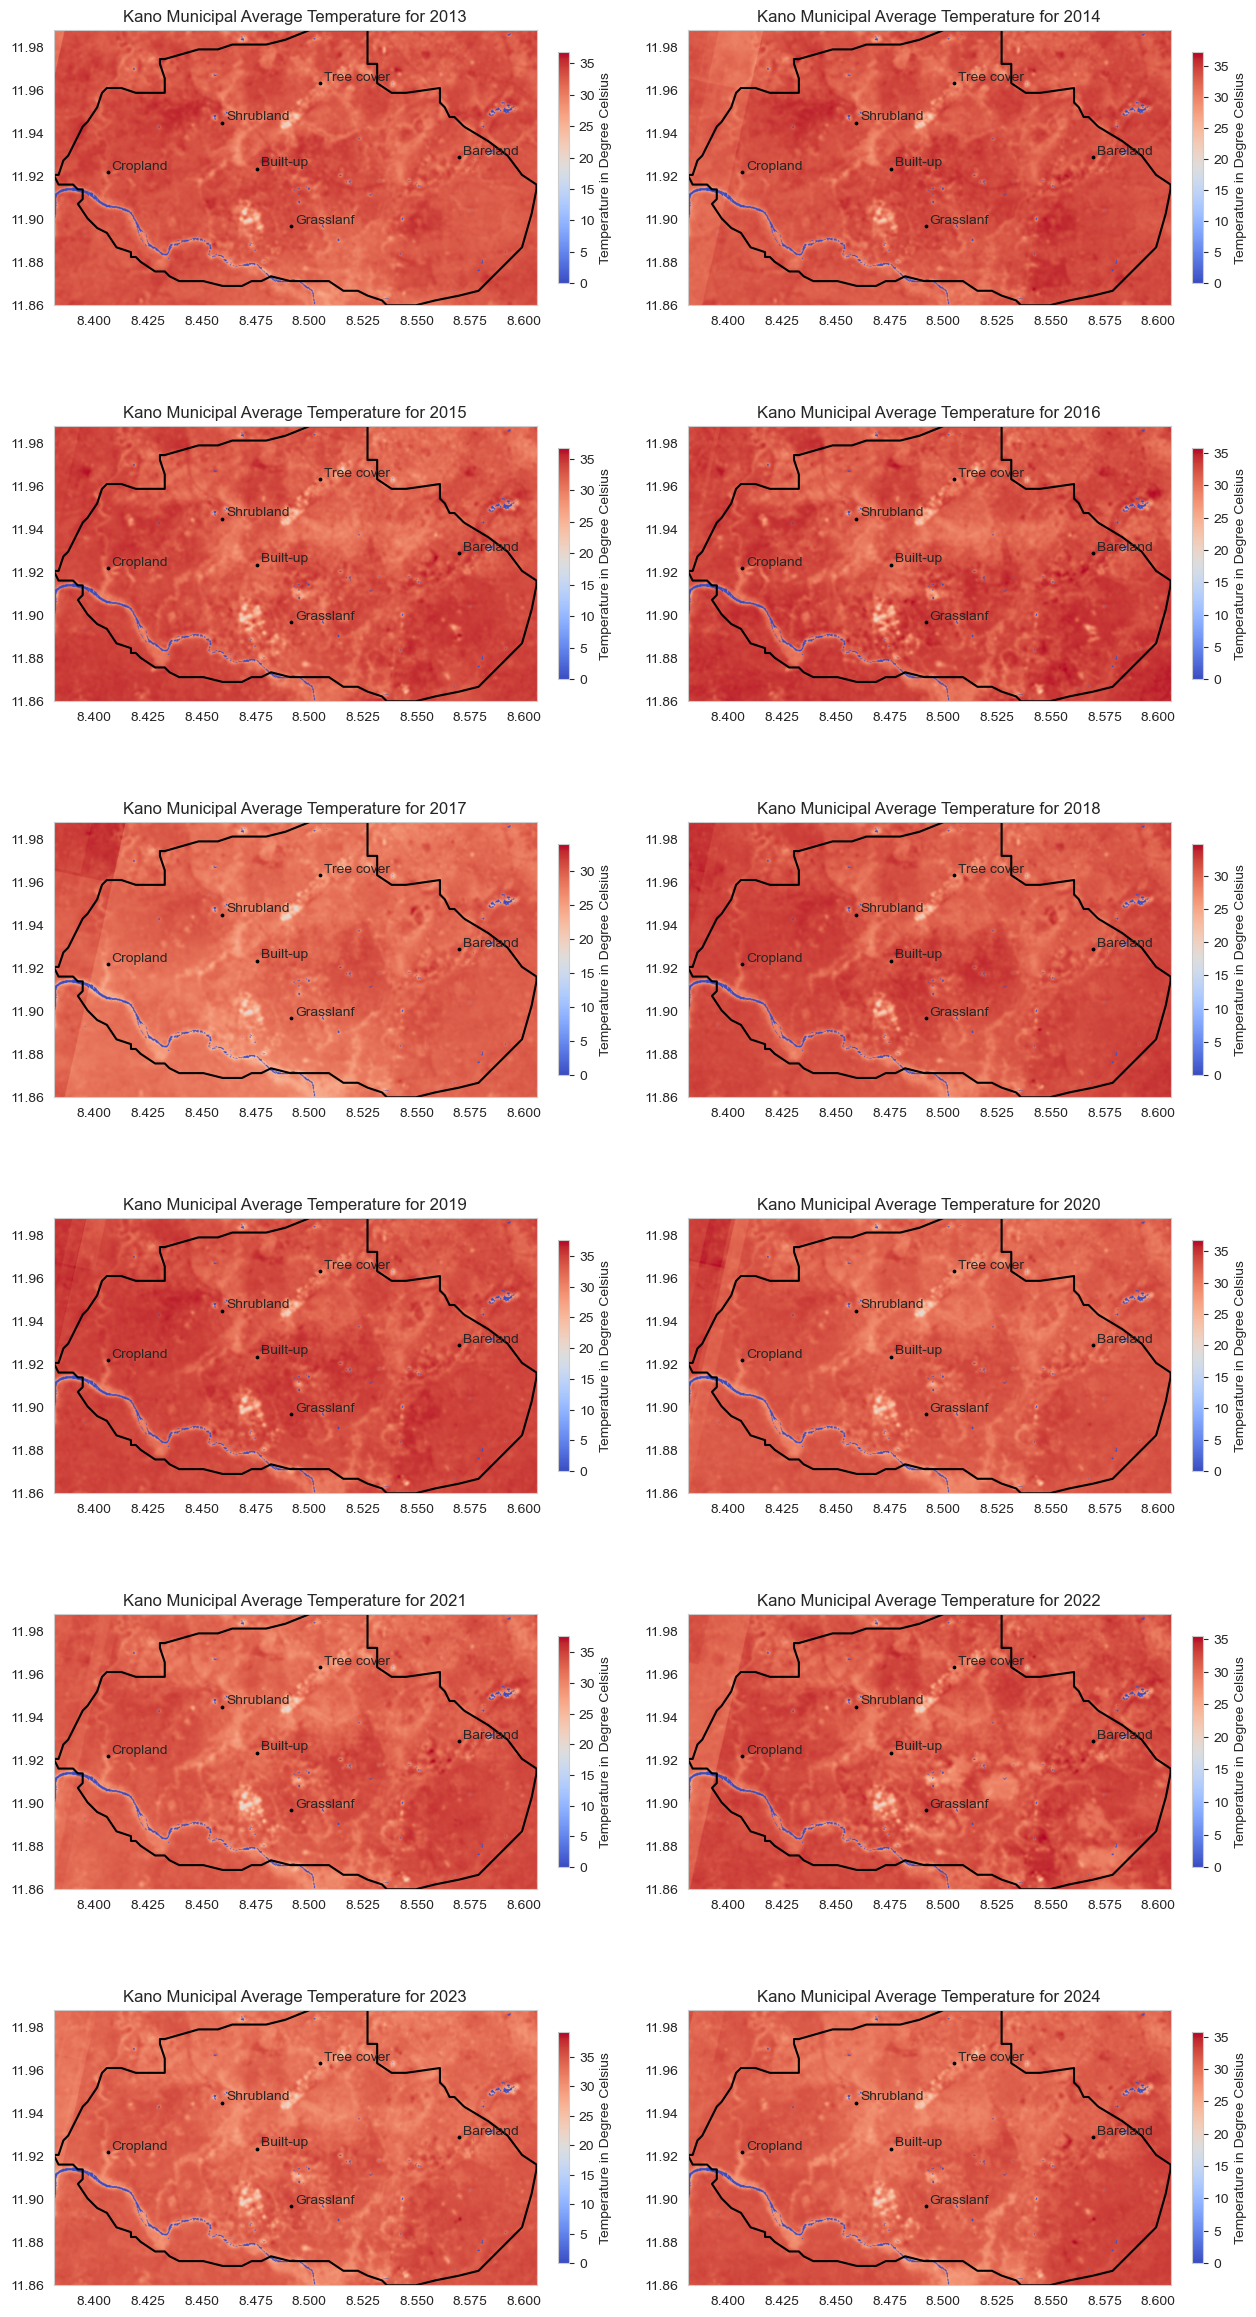

In [168]:
# Path to file
folder_path = "lst files//" 

# Get all TIF files in the folder
tif_files = sorted(glob.glob(os.path.join(folder_path, "*.tif")))

# Calculate grid dimensions for the subplot
n_files = len(tif_files)
n_cols = 2
n_rows = (n_files + n_cols - 1) // n_cols

# Create a figure
plt.figure(figsize=(15, 5 * n_rows))

for i, tif_file in enumerate(tif_files):
    # Read the raster data
    with rasterio.open(tif_file) as src:
        rasterData = src.read(1)
        transform = src.transform
        # Create a subplot
        ax = plt.subplot(n_rows, n_cols, i + 1)
        poi.plot(ax=ax, marker='o',markersize=3, color='black', label='Boundary')
        for x, y, label in zip(poi.geometry.x, poi.geometry.y, poi.landuse):
            ax.annotate(label, xy=(x, y), xytext=(3, 2), textcoords="offset points")
        studyAreadf.boundary.plot(ax=ax, alpha=1, color='black')
        minimumValue = np.min(rasterData)
        maximumValue = np.max(rasterData)
        im = ax.imshow(rasterData, cmap='coolwarm', vmin=minimumValue, vmax=maximumValue)
        im_ = show(rasterData, ax=ax, transform=transform, with_bounds=True, cmap='coolwarm')
        plt.colorbar(im, fraction=0.046, pad=0.04, label='Temperature in Degree Celsius',shrink=0.7)
        titleName = f'Kano Municipal Average Temperature for {2013 + i}'
        plt.title(titleName)
        plt.grid(False)
plt.savefig('results/maps/Yearly_LST.png', dpi=300, bbox_inches='tight')
plt.show()

## Trend Analysis 

In [78]:
poi

id  SAMPLE_1                  geometry     landuse
0  996        50  POINT (8.47564 11.92345)    Built-up
1    0        30   POINT (8.49175 11.8965)   Grasslanf
2  759        40  POINT (8.40619 11.92188)    Cropland
3  804        20  POINT (8.45962 11.94481)   Shrubland
4  766        10  POINT (8.50506 11.96312)  Tree cover
5  786        60  POINT (8.56978 11.92876)    Bareland

In [90]:
 # Create Different LST Based on Land Use
buaLon, buaLat= 8.47564, 11.92345
cropLon, cropLat = 8.40619, 11.92188
bareLon, bareLat = 8.56978, 11.92876
shrubLon, shrubLat = 8.45962, 11.94481
forestLon, forestLat = 8.50506, 11.96312
grassLon, grassLat = 8.49175, 11.8965

In [91]:
# Convert to ee geometry
buaPoi = ee.Geometry.Point(buaLon,buaLat)
cropPoi = ee.Geometry.Point(cropLon,cropLat)
barePoi = ee.Geometry.Point(bareLon,bareLat)
shrubPoi = ee.Geometry.Point(shrubLon,shrubLat)
grassPoi = ee.Geometry.Point(grassLon,grassLat)
forestPoi = ee.Geometry.Point(forestLon,forestLat)
scale = 30

In [138]:
# Define land cover points
land_cover_points = {
    "built up": buaPoi,
    "crop": cropPoi,
    "bareland": barePoi,
    "shrub": shrubPoi,
    "grass": grassPoi,
    "forest": forestPoi
}

# Extract pixel data for each land cover type
lst_data = {key: lstCollection.getRegion(point, 1).getInfo() for key, point in land_cover_points.items()}

# Preview the result for urban area (bua)
lst_data["shrub"][1]

['LC08_188052_20131026',
 8.459619185186774,
 11.94481299298528,
 1382780696663,
 0.14745959639549255,
 0.13351549208164215,
 0.13382117450237274,
 0.1432269811630249,
 0.2922385632991791,
 0.2766719460487366,
 0.19481785595417023,
 0.12533243000507355,
 0.002774714259430766,
 307.6535339355469,
 305.2510070800781,
 21824,
 0,
 13849,
 3237,
 9842,
 580,
 35.45620398026665]

In [141]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['datetime', *list_of_bands]]

    return df

df_data = {key: ee_array_to_df(data, ['LST']) for key, data in lst_data.items()}

In [144]:
# Create individual DataFrames and set 'datetime' as the index
df_bua = df_data["built up"].set_index("datetime")
df_crop = df_data["crop"].set_index("datetime")
df_bare = df_data["bareland"].set_index("datetime")
df_shrub = df_data["shrub"].set_index("datetime")
df_grass = df_data["grass"].set_index("datetime")
df_forest = df_data["forest"].set_index("datetime")

df_bua.head()

0                              LST
datetime                          
2013-10-26 09:44:56.663  34.226673
2013-11-11 09:44:56.117  35.419014
2013-11-27 09:44:48.819  34.384484
2013-12-13 09:44:45.968  27.122378
2013-12-29 09:44:37.322  33.031330

In [145]:
# Save each Land use LST
# Define file names
file_paths = {
    "built up": "results/tables/bua_data.csv",
    "crop": "results/tables/crop_data.csv",
    "bareland": "results/tables/bare_data.csv",
    "shrub": "results/tables/shrub_data.csv",
    "grass": "results/tables/grass_data.csv",
    "forest": "results/tables/forest_data.csv"
}

# Save each DataFrame as a CSV file
df_bua.to_csv(file_paths["built up"])
df_crop.to_csv(file_paths["crop"])
df_bare.to_csv(file_paths["bareland"])
df_shrub.to_csv(file_paths["shrub"])
df_grass.to_csv(file_paths["grass"])
df_forest.to_csv(file_paths["forest"])

print("CSV files saved successfully!")


CSV files saved successfully!


### Visualize each Land Use Temperature 

In [146]:
# Compute descriptive statistics for each land cover type
print("Time differences between consecutive observations:")
timeDiffs = {key: df['datetime'].diff() for (key,df) in df_data.items()}
desc_stats = {key: df.describe() for key, df in df_data.items()}
print("Descriptive Statistics for Built-up Area:\n", desc_stats)

Time differences between consecutive observations:
Descriptive Statistics for Built-up Area:
 {'built up': 0                           datetime        LST
count                             80  80.000000
mean   2019-03-31 19:19:23.928787712  31.349176
min       2013-10-26 09:44:56.663000  22.417099
25%    2016-09-08 09:43:23.828250112  28.992865
50%    2019-01-04 09:43:03.888999936  31.380293
75%    2022-02-01 09:43:20.661999872  34.246768
max       2024-12-27 09:43:14.740000  39.915497
std                              NaN   3.835896, 'crop': 0                           datetime        LST
count                             80  80.000000
mean   2019-03-31 19:19:23.928787712  32.533005
min       2013-10-26 09:44:56.663000  14.508410
25%    2016-09-08 09:43:23.828250112  30.441261
50%    2019-01-04 09:43:03.888999936  32.896936
75%    2022-02-01 09:43:20.661999872  35.391822
max       2024-12-27 09:43:14.740000  42.215198
std                              NaN   4.199885, 'bareland': 0      

In [147]:
# Save the descriptive statistics 
descStat = {key: f'results/tables/{key}_descriptive_stat.csv' for key in desc_stats.keys()}

for key, df in df_data.items():
    desc_stats = df.describe() 
    desc_stats.to_csv(descStat[key]) 

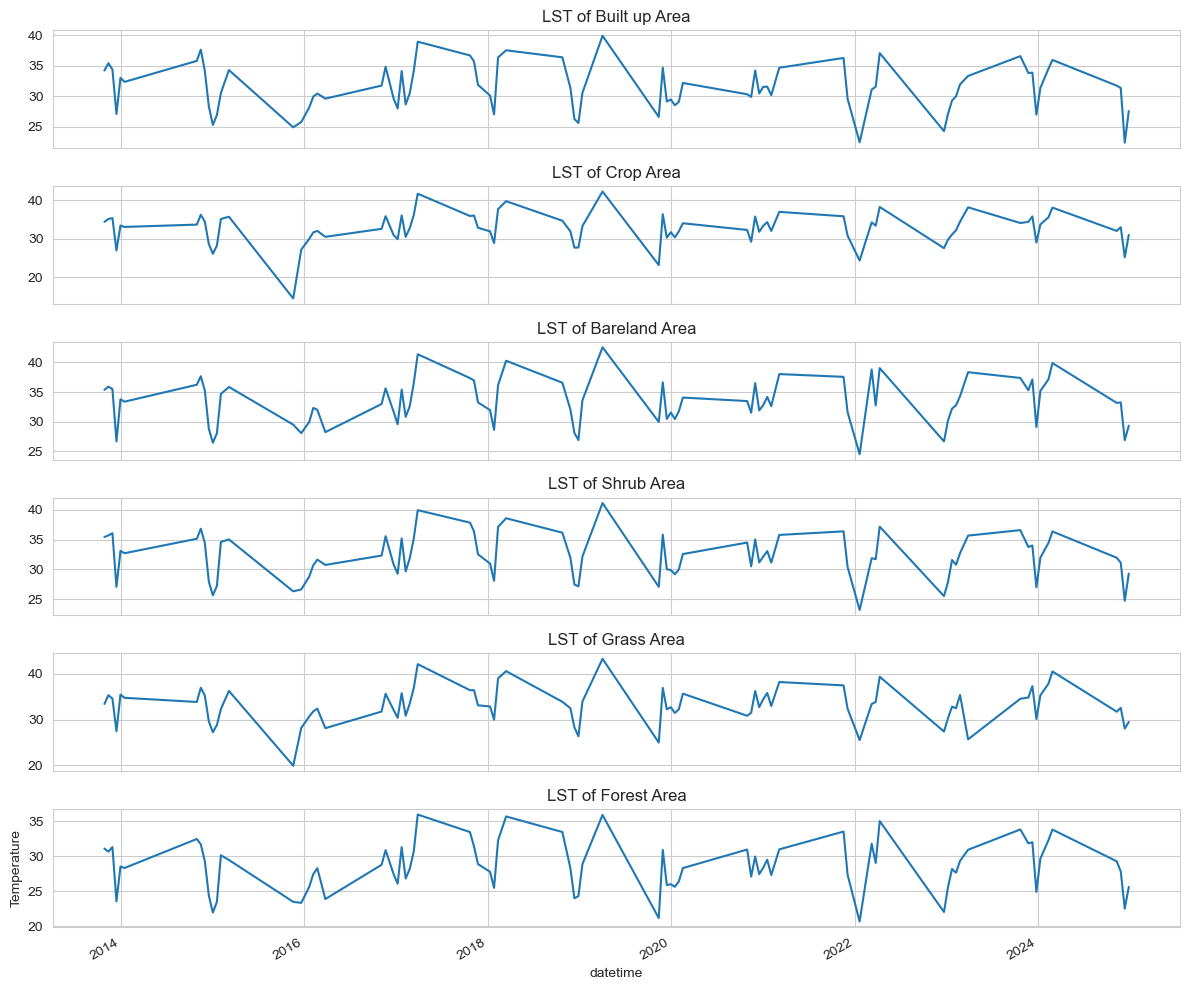

In [148]:
fig, axes = plt.subplots(len(df_data), 1, figsize=(12, 10), sharex=True)

# Dictionary comprehension to plot each DataFrame
plots = {key: df.set_index("datetime").plot(ax=axes[i], title=f"LST of {key.capitalize()} Area", legend=False, ) 
         for i, (key, df) in enumerate(df_data.items())}
plt.ylabel("Temperature", loc='center')
plt.tight_layout()
plt.savefig('results/figures/Temperature_Distibution_by_LandUse.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical Analysis 

### Calculate Mann-Kendall Trend Test for each Land Cover Type to Check if there is Trend

In [149]:
# Function to perform Mann-Kendall test on LST data
def perform_mann_kendall_test(time_series, alpha=0.05):    
    # Original Mann-Kendall test
    result = mk.original_test(time_series, alpha=alpha)
    
    return {
        'trend': result.trend,
        'h': result.h,  # True if trend is present
        'p_value': result.p,
        'z': result.z,
        'tau': result.Tau,
        's': result.s,
        'var_s': result.var_s,
        'slope': result.slope,
        'intercept': result.intercept
    }

In [151]:
lst_df = {key: df.set_index('datetime').resample('M').mean().fillna(method='ffill') for key, df in df_data.items()}

In [169]:
results = {key: perform_mann_kendall_test(df['LST']) for key,df in df_data.items()}

for key, df in results.items():
    # Print results
    print('***'*20)
    print(f"Mann-Kendall Test Results for {key} LST Analysis:")
    print('***'*20)
    print(f"Trend: {df['trend']}")
    print(f"p-value: {df['p_value']:.6f}")
    print(f"Kendall's tau: {df['tau']:.6f}")
    print(f"Sen's slope: {df['slope']:.6f}")

************************************************************
Mann-Kendall Test Results for built up LST Analysis:
************************************************************
Trend: no trend
p-value: 0.806360
Kendall's tau: -0.018987
Sen's slope: -0.004439
************************************************************
Mann-Kendall Test Results for crop LST Analysis:
************************************************************
Trend: no trend
p-value: 0.574880
Kendall's tau: 0.043038
Sen's slope: 0.010216
************************************************************
Mann-Kendall Test Results for bareland LST Analysis:
************************************************************
Trend: no trend
p-value: 0.324794
Kendall's tau: 0.075316
Sen's slope: 0.020615
************************************************************
Mann-Kendall Test Results for shrub LST Analysis:
************************************************************
Trend: no trend
p-value: 0.768008
Kendall's tau: -0.022785
Sen's 

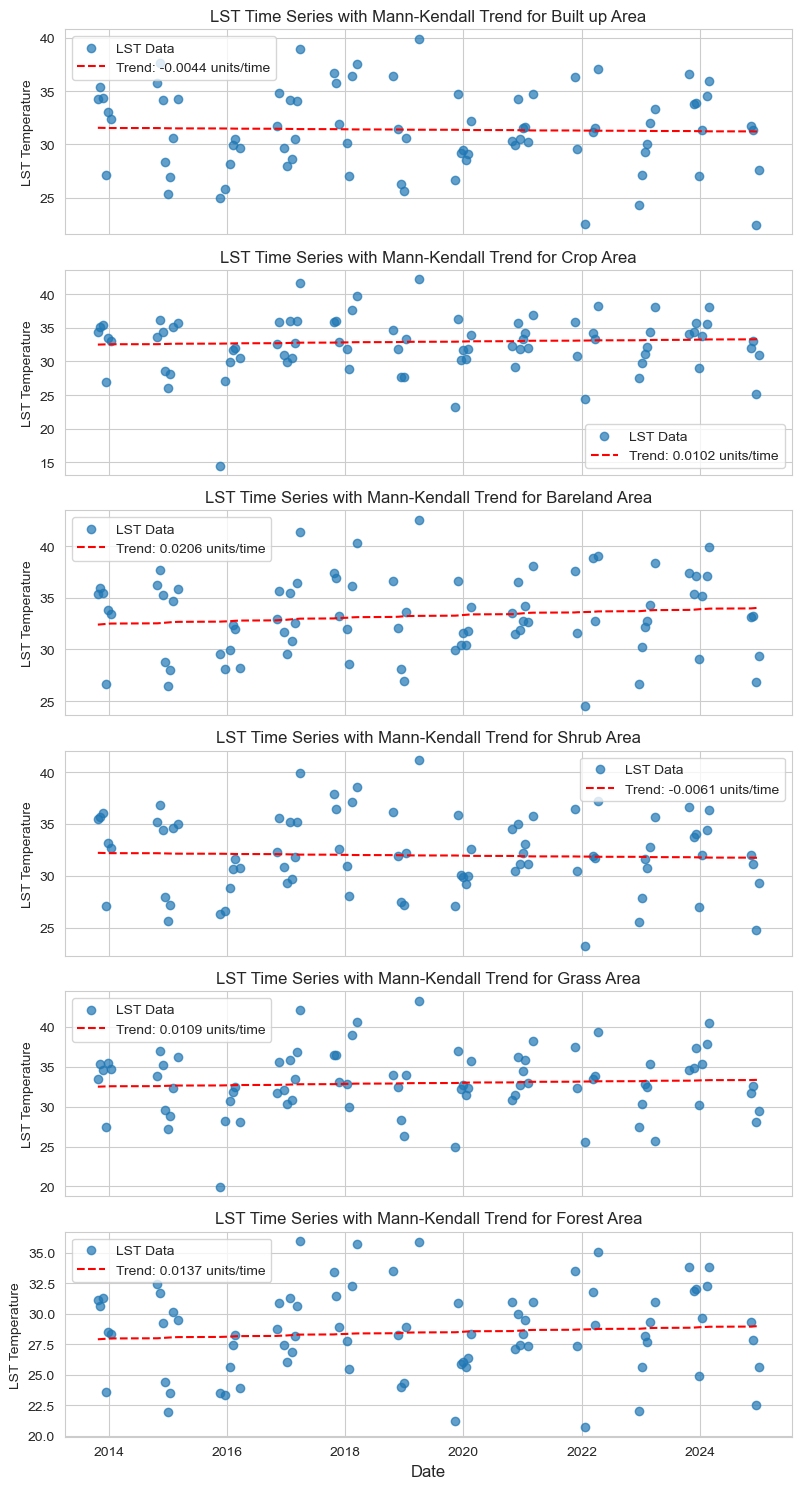

In [176]:
# Set plot style
sns.set_style("whitegrid")

# Create subplots for all land cover types
fig, axes = plt.subplots(len(df_data), 1, figsize=(8, 15), sharex=True)

for i, (key, df) in enumerate(df_data.items()):
    ax = axes[i]
    
    ax.scatter(df.datetime, df.LST, alpha=0.7, label="LST Data")

    x = np.arange(len(df))
    trend_line = results[key]['slope'] * x + results[key]['intercept']
    
    ax.plot(df.datetime, trend_line, 'r--', label=f"Trend: {results[key]['slope']:.4f} units/time")

    ax.set_title(f"LST Time Series with Mann-Kendall Trend for {key.capitalize()} Area", fontsize=12)
    ax.set_ylabel("LST Temperature")
    ax.legend()

plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/figures/LST_Trend_Analysis.png", dpi=300, bbox_inches='tight') 
plt.show()

In [154]:
# Seasonal Variation using Mann-Kendall 
seasonalVariation = {key: mk.seasonal_test(df['LST'].values, period=12) for key,df in lst_df.items()}

for key, df in seasonalVariation.items():
    seasonal_results = {
    'trend': df.trend,
    'h': df.h,
    'p_value': df.p,
    'z': df.z,
    's': df.s,
    'var_s': df.var_s,
    'slope': df.slope,
    'intercept': df.intercept
    }
    
    print('***'*20)
    print(f"Mann-Kendall Test Results for {key} LST Analysis:")
    print('***'*20)
    print(f"Trend: {seasonal_results['trend']}")
    print(f"p-value: {seasonal_results['p_value']:.6f}")
    print(f"Sen's slope: {seasonal_results['slope']:.6f}")

************************************************************
Mann-Kendall Test Results for built up LST Analysis:
************************************************************
Trend: no trend
p-value: 0.068292
Sen's slope: 0.112608
************************************************************
Mann-Kendall Test Results for crop LST Analysis:
************************************************************
Trend: increasing
p-value: 0.009204
Sen's slope: 0.211109
************************************************************
Mann-Kendall Test Results for bareland LST Analysis:
************************************************************
Trend: increasing
p-value: 0.000189
Sen's slope: 0.296801
************************************************************
Mann-Kendall Test Results for shrub LST Analysis:
************************************************************
Trend: no trend
p-value: 0.385323
Sen's slope: 0.080833
************************************************************
Mann-Kendall Test 

### Quantile Regeression Analysis (QRA)

In [155]:
def quantile_regression_analysis(data, landuse):
    time_idx = np.arange(len(data))
    x= time_idx.reshape(-1,1)
    y = data.values

    quantile = [0.1, 0.25, 0.5, 0.75, 0.9]
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    plt.scatter(time_idx, y, color='gray', alpha=0.5)
    result = {}
    for q,color in zip(quantile,colors):
        qr = QuantileRegressor(quantile=q, solver='highs', alpha=0)
        qr.fit(x,y)
        y_pred = qr.predict(x)
        plt.plot(time_idx,y_pred,color=color, label=f"Q({q})")
        slope = qr.coef_[0]
        result[f"Q{q}"]=slope
        print(f"Quantile {q}: slope = {slope:.6f}")
    plt.title(f"Quantile Regression Analysis for {landuse.capitalize()}")
    plt.xlabel("Time")
    plt.grid(True)
    plt.legend()
    plt.ylabel('Temperature')
    plt.savefig(f"results/figures//quantile regression/quantile Regression for {landuse.capitalize()}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Test if the slopes are significantly different
    slope = list(result.values())
    if len(slope)>1:
        f_stat, p_value = stats.f_oneway(*[[s] for s in slope])
        print(f'F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}')
        if p_value < 0.05:
            print("The slopes across quantiles are significantly different.")
        else:
            print("No significant difference in slopes across quantiles.")
    
    return results

************************************************************
Quantile Regression Analysis of Built up
************************************************************
Quantile 0.1: slope = 0.015008
Quantile 0.25: slope = 0.023755
Quantile 0.5: slope = 0.022609
Quantile 0.75: slope = 0.007201
Quantile 0.9: slope = -0.008581


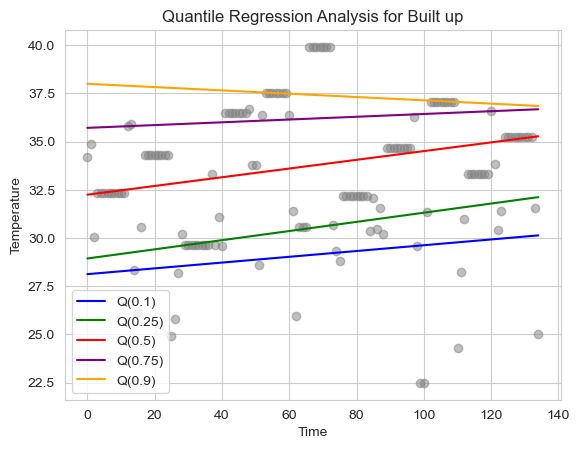

F-statistic: nan, p-value: nan
No significant difference in slopes across quantiles.
************************************************************
Quantile Regression Analysis of Crop
************************************************************
Quantile 0.1: slope = 0.008713
Quantile 0.25: slope = 0.029358
Quantile 0.5: slope = 0.030498
Quantile 0.75: slope = 0.025632
Quantile 0.9: slope = -0.024453


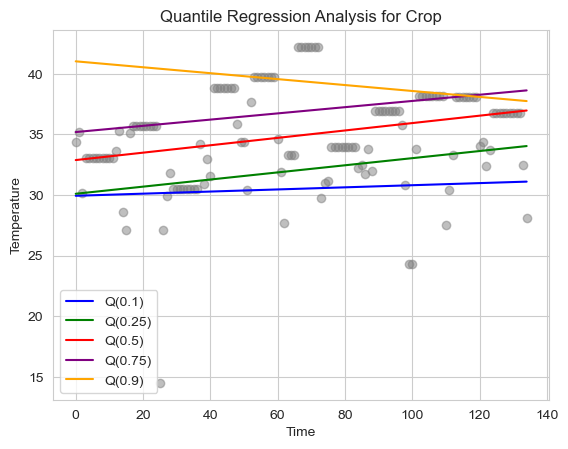

F-statistic: nan, p-value: nan
No significant difference in slopes across quantiles.
************************************************************
Quantile Regression Analysis of Bareland
************************************************************
Quantile 0.1: slope = 0.048749
Quantile 0.25: slope = 0.043977
Quantile 0.5: slope = 0.042057
Quantile 0.75: slope = 0.023058
Quantile 0.9: slope = -0.022647


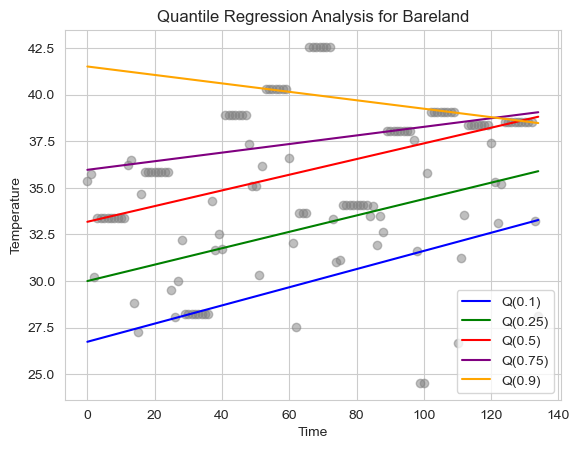

F-statistic: nan, p-value: nan
No significant difference in slopes across quantiles.
************************************************************
Quantile Regression Analysis of Shrub
************************************************************
Quantile 0.1: slope = 0.011303
Quantile 0.25: slope = 0.029743
Quantile 0.5: slope = 0.022076
Quantile 0.75: slope = 0.008930
Quantile 0.9: slope = -0.026201


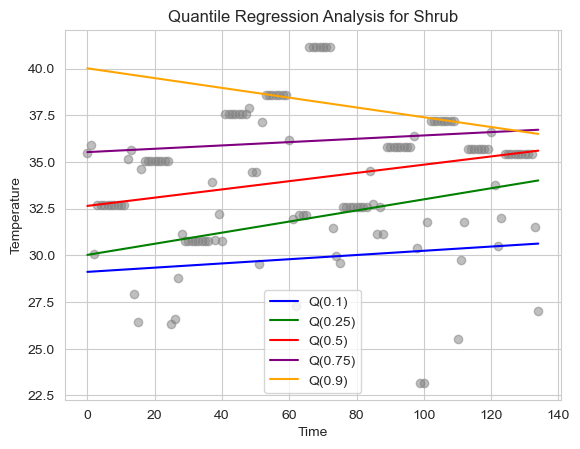

F-statistic: nan, p-value: nan
No significant difference in slopes across quantiles.
************************************************************
Quantile Regression Analysis of Grass
************************************************************
Quantile 0.1: slope = -0.028710
Quantile 0.25: slope = 0.000478
Quantile 0.5: slope = 0.012926
Quantile 0.75: slope = 0.027618
Quantile 0.9: slope = -0.018106


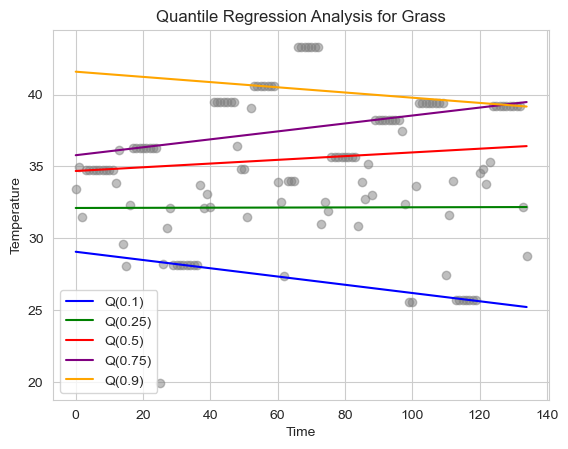

F-statistic: nan, p-value: nan
No significant difference in slopes across quantiles.
************************************************************
Quantile Regression Analysis of Forest
************************************************************
Quantile 0.1: slope = 0.046793
Quantile 0.25: slope = 0.029460
Quantile 0.5: slope = 0.029967
Quantile 0.75: slope = 0.022883
Quantile 0.9: slope = -0.012253


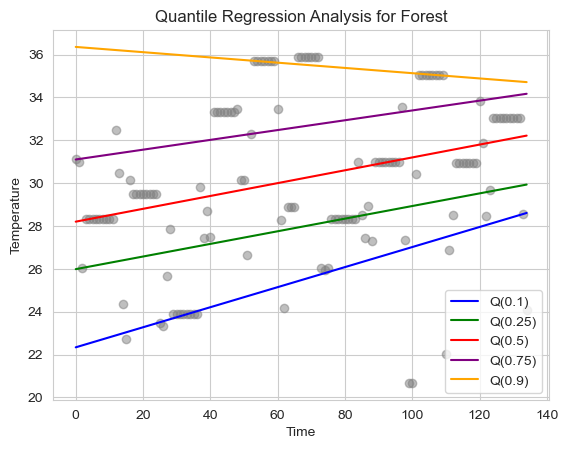

F-statistic: nan, p-value: nan
No significant difference in slopes across quantiles.


In [156]:
quantile_results = {}
for key, df in lst_df.items():
    print("***" * 20)
    print(f'Quantile Regression Analysis of {key.capitalize()}')
    print("***" * 20)
    quantile_results[key] = quantile_regression_analysis(df,key)

### Seasonal Decomposition Analysis

In [159]:
def seasonal_decomposition_analysis(data, landuse, period=163):
    """Decompose time series into trend, seasonal, and residual components."""
    
    data = data.asfreq('D').interpolate()
    
    # Perform decomposition
    decomposition = seasonal_decompose(data, model='additive', period=period)
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title(f'Observed LST in {landuse.capitalize()}')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title(f'Trend LST in {landuse.capitalize()}')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title(f'Seasonal LST in {landuse.capitalize()}')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title(f'Residual LST in {landuse.capitalize()}')
    plt.tight_layout()
    plt.savefig(f'results/figures//seasonal decomposition/seasonal decomposition for {landuse.capitalize()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate variance explained by each component
    total_var = decomposition.observed.var()
    trend_var = decomposition.trend.var()
    seasonal_var = decomposition.seasonal.var()
    resid_var = decomposition.resid.var()
    
    print(f"Variance explained by trend: {trend_var/total_var*100:.2f}%")
    print(f"Variance explained by seasonality: {seasonal_var/total_var*100:.2f}%")
    print(f"Variance explained by residuals: {resid_var/total_var*100:.2f}%")
    
    return decomposition

************************************************************
Seasonal Decomposition Analysis of Built up
************************************************************


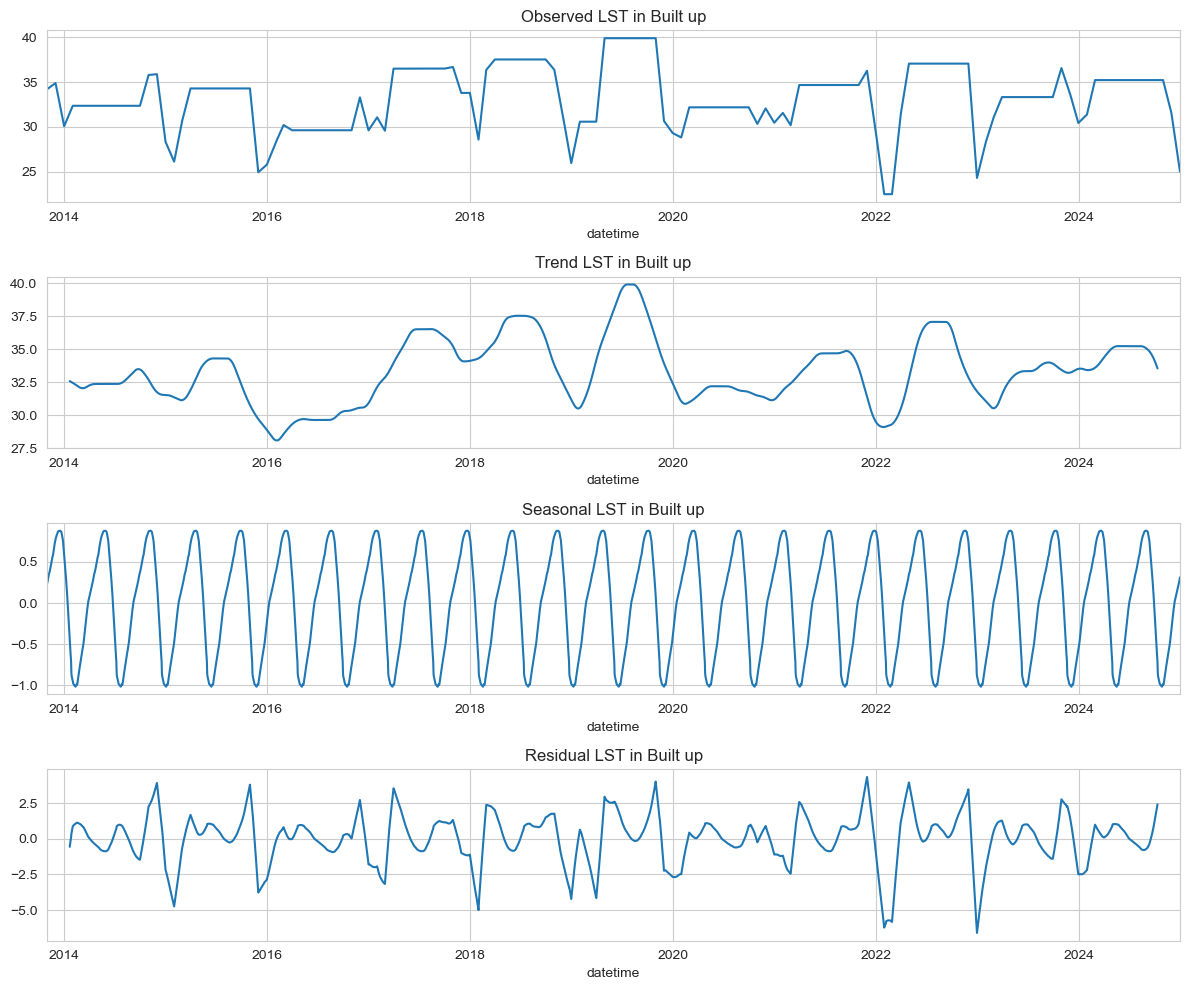

Variance explained by trend: 52.62%
Variance explained by seasonality: 3.62%
Variance explained by residuals: 24.81%
************************************************************
Seasonal Decomposition Analysis of Crop
************************************************************


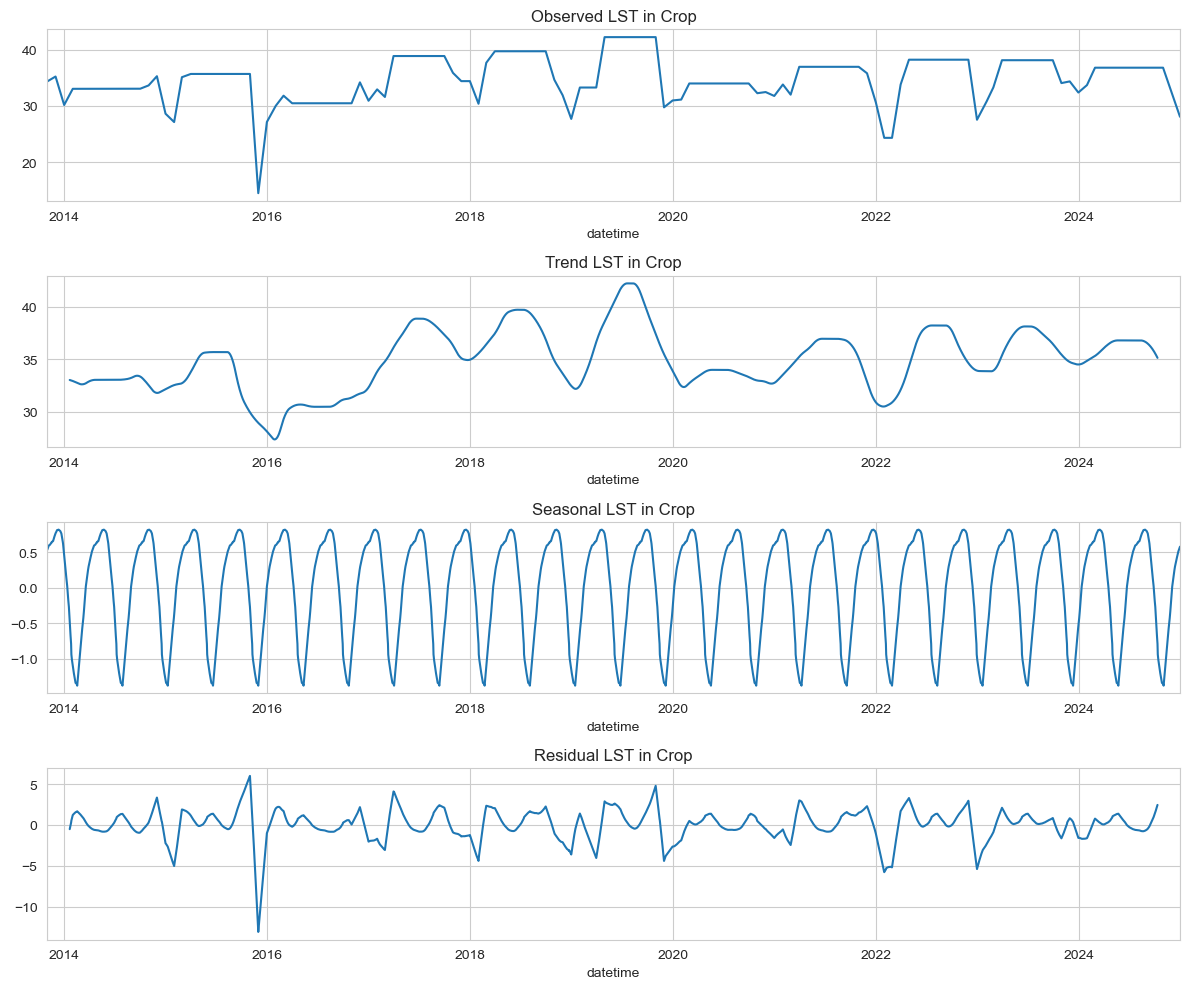

Variance explained by trend: 55.99%
Variance explained by seasonality: 3.63%
Variance explained by residuals: 23.50%
************************************************************
Seasonal Decomposition Analysis of Bareland
************************************************************


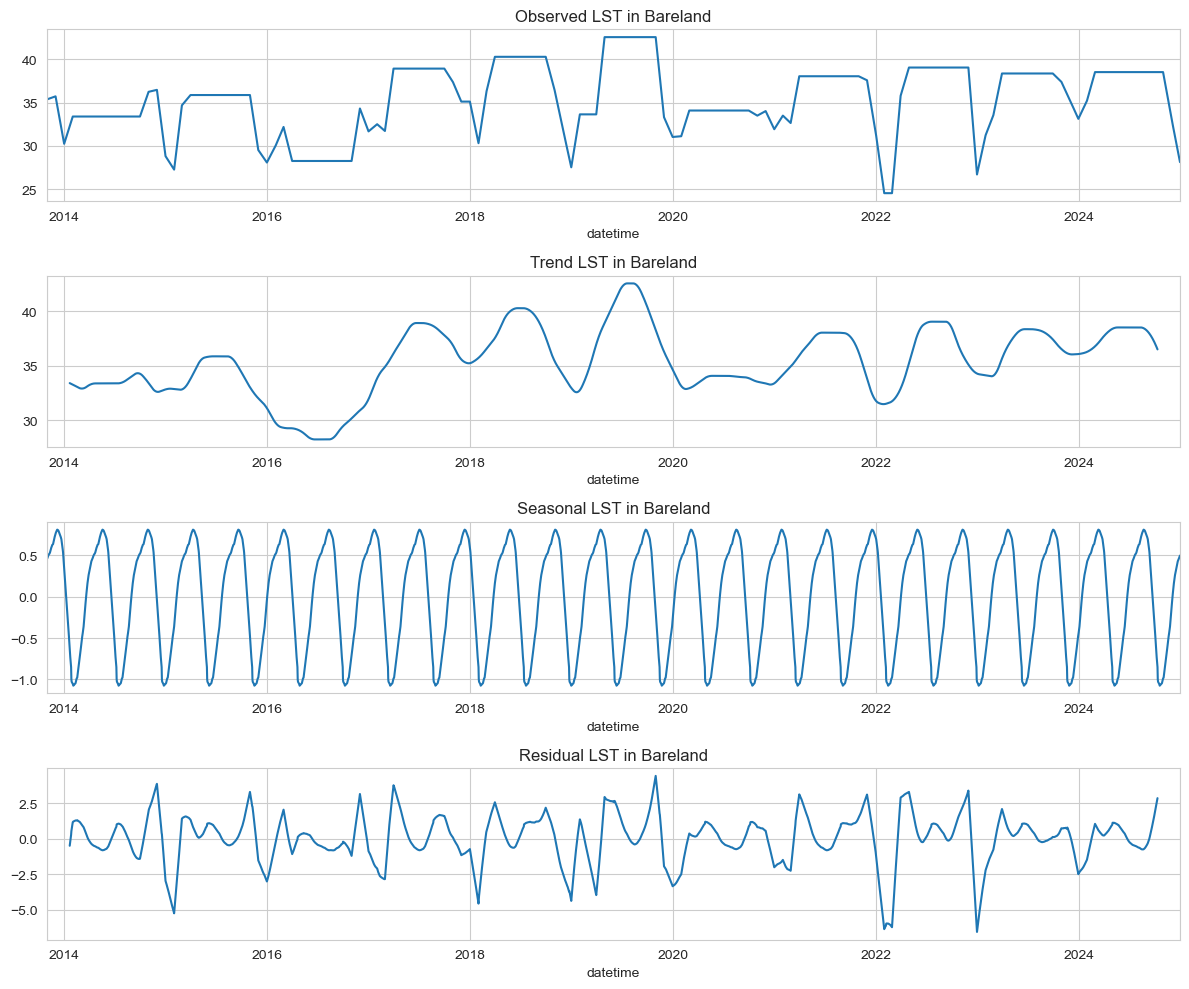

Variance explained by trend: 62.34%
Variance explained by seasonality: 2.74%
Variance explained by residuals: 18.67%
************************************************************
Seasonal Decomposition Analysis of Shrub
************************************************************


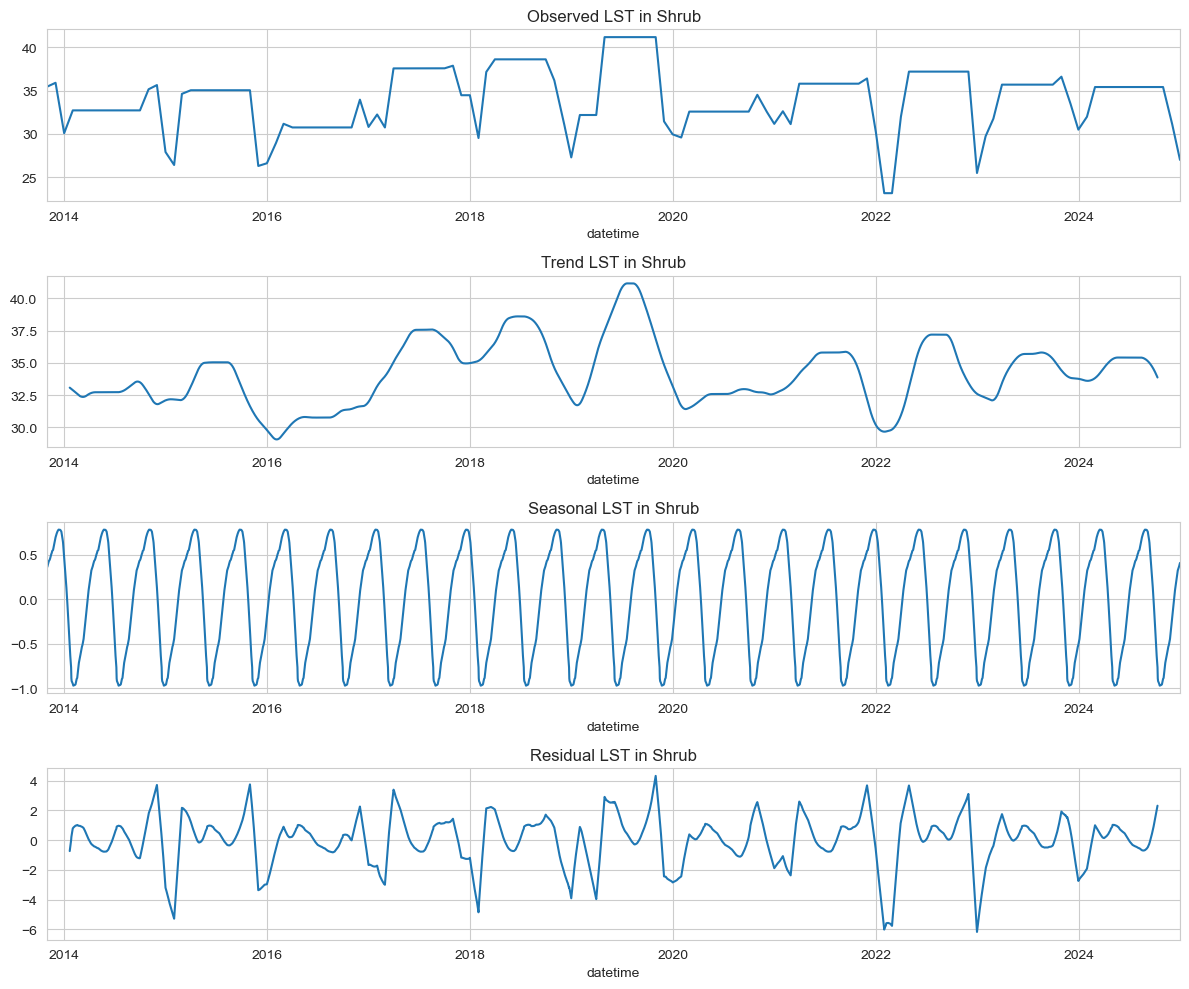

Variance explained by trend: 53.97%
Variance explained by seasonality: 3.16%
Variance explained by residuals: 23.87%
************************************************************
Seasonal Decomposition Analysis of Grass
************************************************************


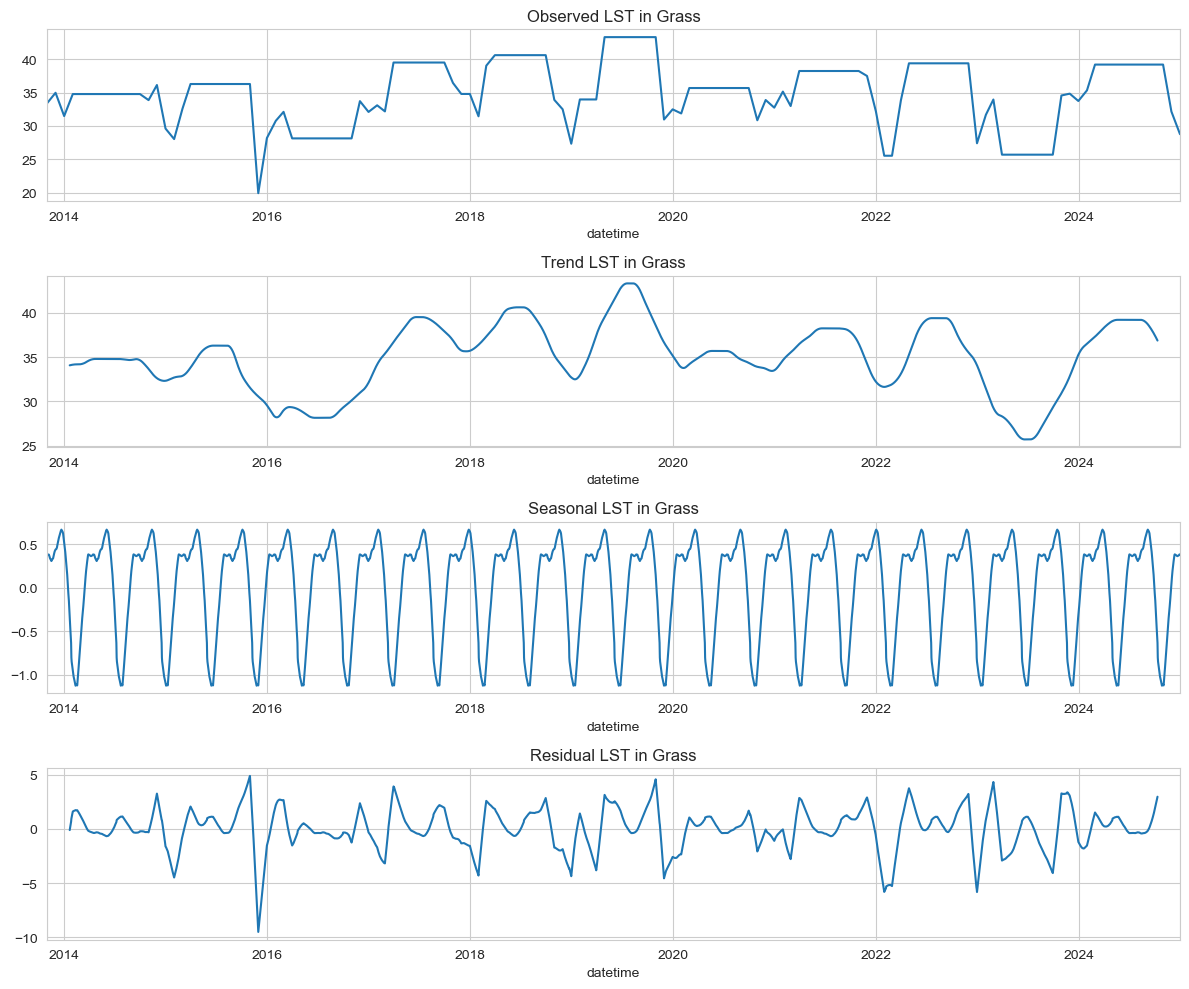

Variance explained by trend: 68.78%
Variance explained by seasonality: 1.57%
Variance explained by residuals: 16.14%
************************************************************
Seasonal Decomposition Analysis of Forest
************************************************************


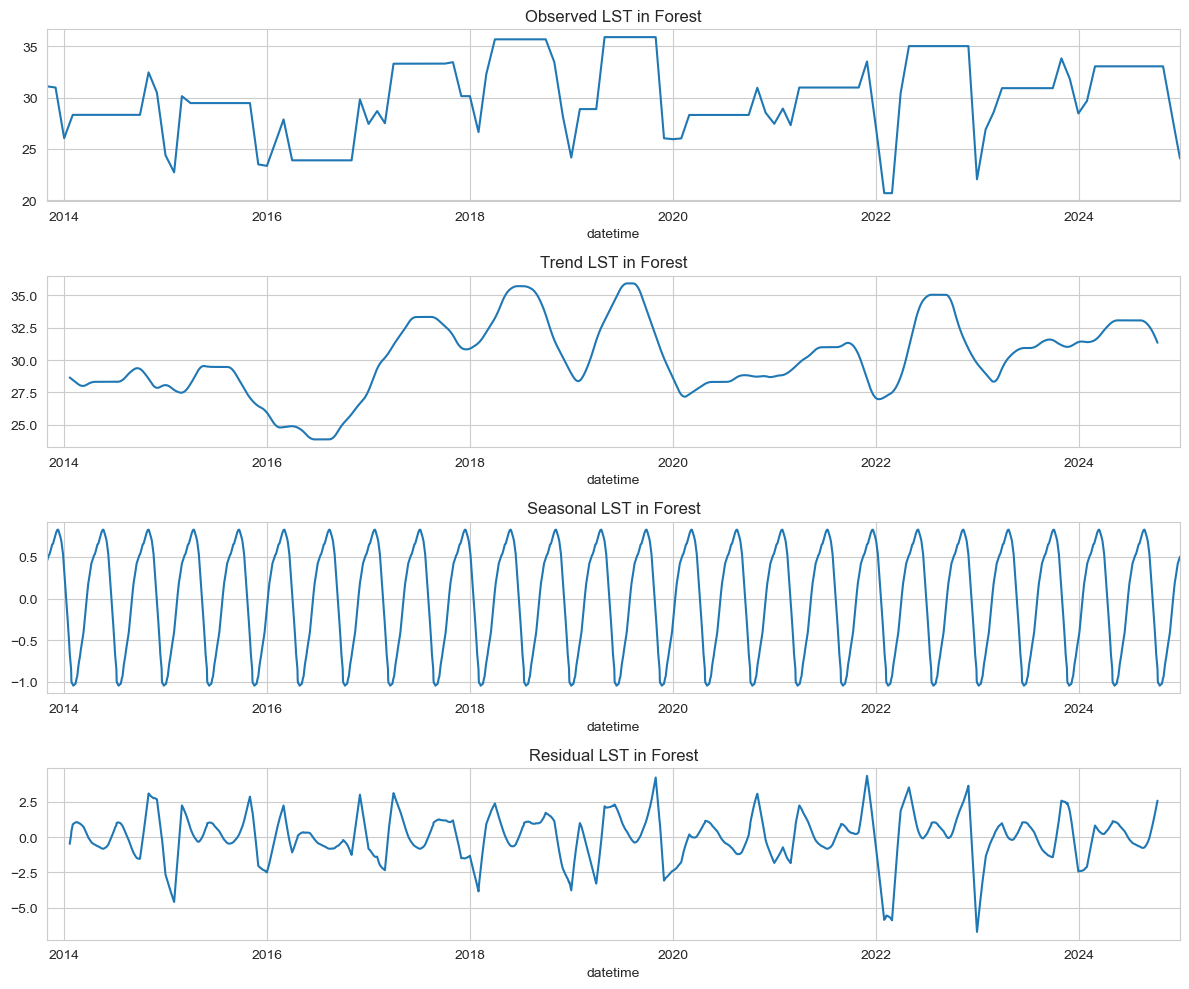

Variance explained by trend: 63.66%
Variance explained by seasonality: 3.24%
Variance explained by residuals: 19.82%


In [160]:
sda_results = {}
for key, df in lst_df.items():
    print("***" * 20)
    print(f'Seasonal Decomposition Analysis of {key.capitalize()}')
    print("***" * 20)
    sda_results[key] = seasonal_decomposition_analysis(df,landuse=key)

### Extreme Value Analysis

In [174]:
def extreme_value_analysis(data, landuse, threshold_percentile=95):
    """Analyze extreme values in the time series."""
    print("Extreme Value Analysis")
    
    # Define thresholds for extreme values
    upper_threshold = np.percentile(data, threshold_percentile)
    lower_threshold = np.percentile(data, 100 - threshold_percentile)
    
    # Identify extreme values
    extreme_high = data[data > upper_threshold]
    extreme_low = data[data < lower_threshold]
    
    print(f"Upper threshold ({threshold_percentile}th percentile): {upper_threshold:.2f}")
    print(f"Lower threshold ({100-threshold_percentile}th percentile): {lower_threshold:.2f}")
    print(f"Number of extreme high values: {len(extreme_high)}")
    print(f"Number of extreme low values: {len(extreme_low)}")
    
    # Plot time series with extreme values highlighted
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data, alpha=0.5, color='gray', label='Data')
    plt.scatter(extreme_high.index, extreme_high, color='red', label='Extreme High')
    plt.scatter(extreme_low.index, extreme_low, color='blue', label='Extreme Low')
    plt.axhline(y=upper_threshold, color='red', linestyle='--', alpha=0.7)
    plt.axhline(y=lower_threshold, color='blue', linestyle='--', alpha=0.7)
    plt.title(f'Time Series with Extreme Values for {landuse.capitalize()}')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'results/figures//extreme values/extreme values timeseries {landuse.capitalize()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyze distribution of extreme values over time
    years = [date.year for date in data.index]
    min_year, max_year = min(years), max(years)
    year_range = range(min_year, max_year + 1)
    
    # Count extreme events by year
    extreme_high_by_year = [sum(1 for date in extreme_high.index if date.year == year) for year in year_range]
    extreme_low_by_year = [sum(1 for date in extreme_low.index if date.year == year) for year in year_range]
    
    # Plot extreme events by year
    plt.figure(figsize=(12, 6))
    plt.bar(year_range, extreme_high_by_year, color='red', alpha=0.7, label='Extreme High')
    plt.bar(year_range, extreme_low_by_year, color='blue', alpha=0.7, label='Extreme Low')
    plt.title(f'Extreme Events by Year for {landuse.capitalize()}')
    plt.xlabel('Year')
    plt.ylabel('Number of Extreme Events')
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig(f"results/figures//extreme values/extreme events for {landuse.capitalize()}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test for trends in extreme events
    if len(year_range) > 20:
        high_events = pd.Series(extreme_high_by_year, index=year_range)
        low_events = pd.Series(extreme_low_by_year, index=year_range)
        
        mk_high = mk.original_test(high_events)
        mk_low = mk.original_test(low_events)
        
        print(f"Mann-Kendall test on extreme high events: trend = {mk_high.trend}, p-value = {mk_high.p:.4f}")
        print(f"Mann-Kendall test on extreme low events: trend = {mk_low.trend}, p-value = {mk_low.p:.4f}")
    
    return {
        'extreme_high': extreme_high,
        'extreme_low': extreme_low,
        'extreme_high_by_year': extreme_high_by_year,
        'extreme_low_by_year': extreme_low_by_year
    }

************************************************************
Extreme Value Analysis of Built up
************************************************************
Extreme Value Analysis
Upper threshold (95th percentile): 38.25
Lower threshold (5th percentile): 26.07
Number of extreme high values: 135
Number of extreme low values: 135


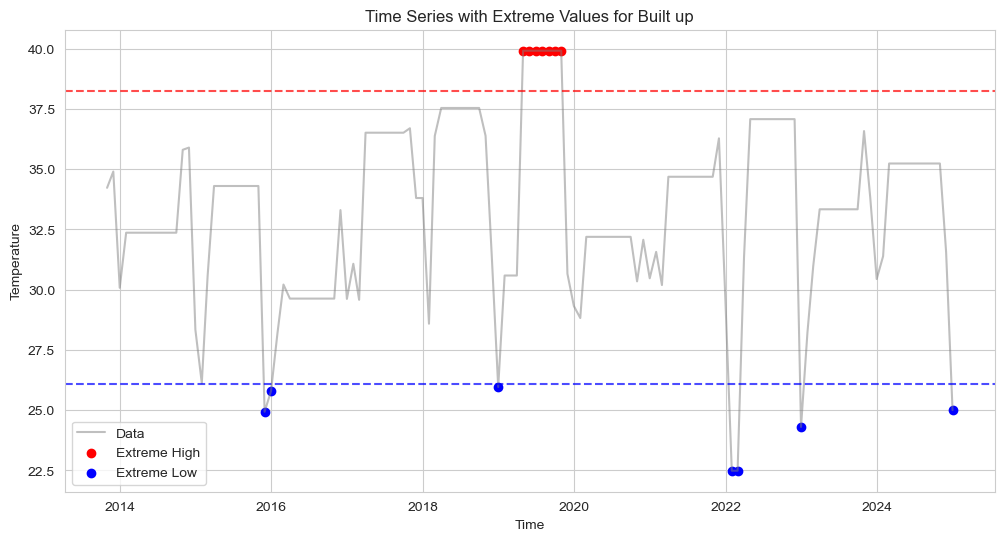

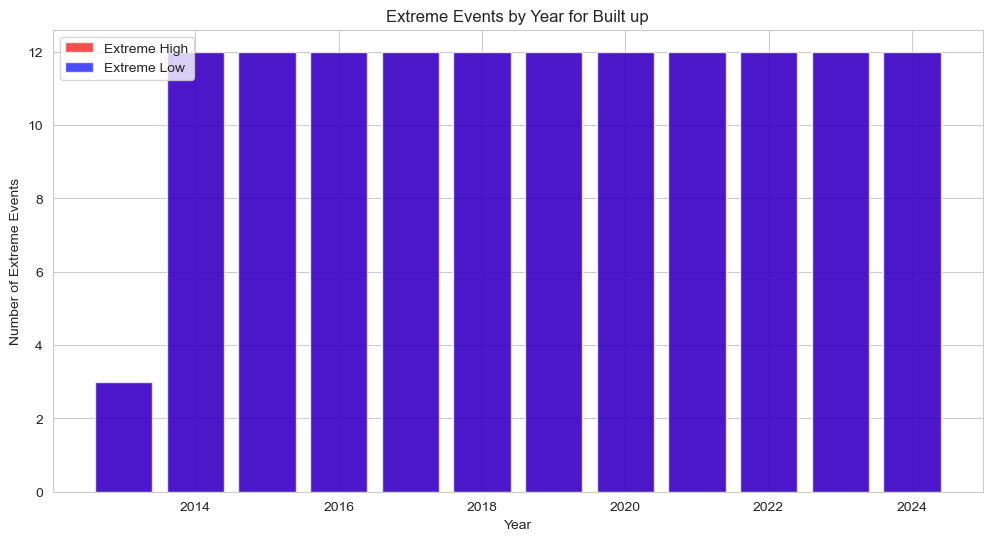

************************************************************
Extreme Value Analysis of Crop
************************************************************
Extreme Value Analysis
Upper threshold (95th percentile): 40.46
Lower threshold (5th percentile): 27.96
Number of extreme high values: 135
Number of extreme low values: 135


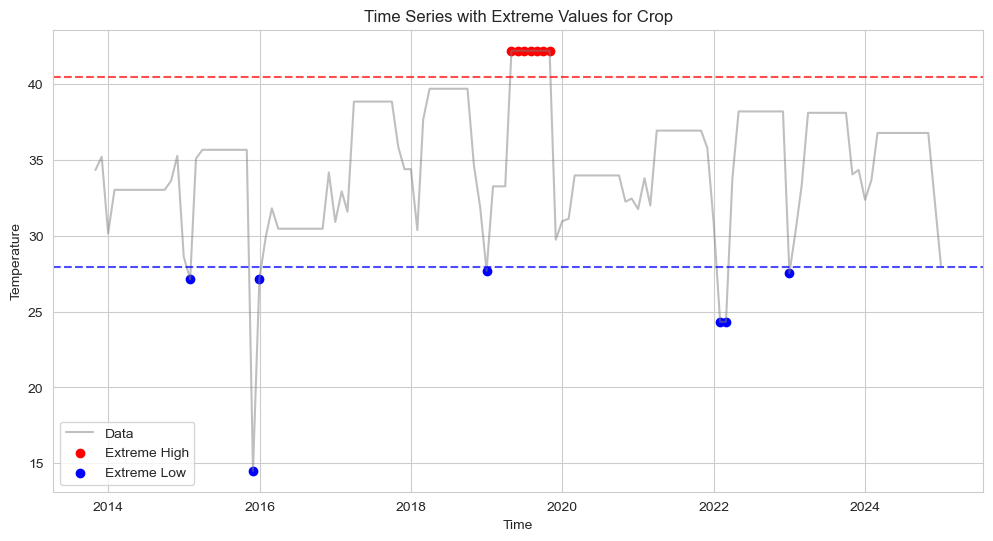

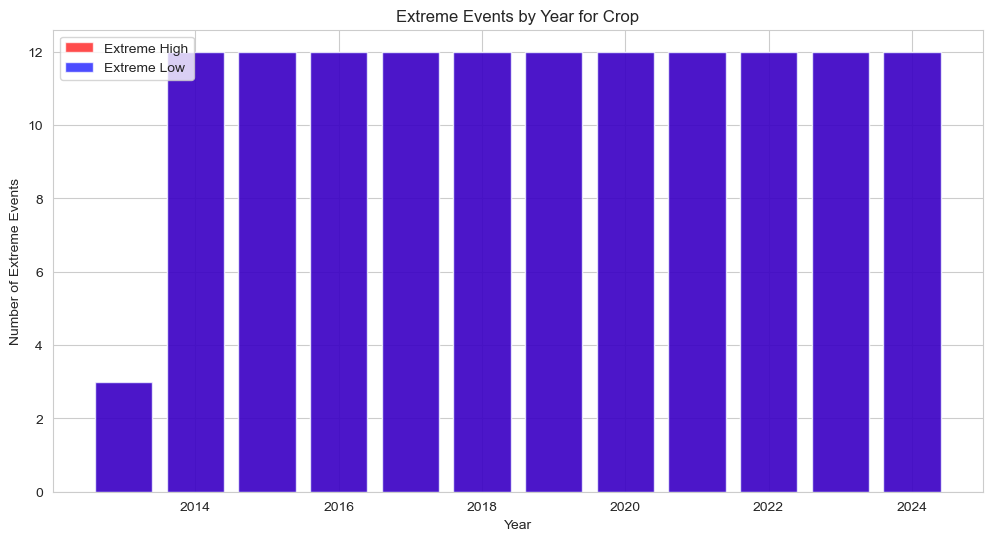

************************************************************
Extreme Value Analysis of Bareland
************************************************************
Extreme Value Analysis
Upper threshold (95th percentile): 40.96
Lower threshold (5th percentile): 28.21
Number of extreme high values: 135
Number of extreme low values: 135


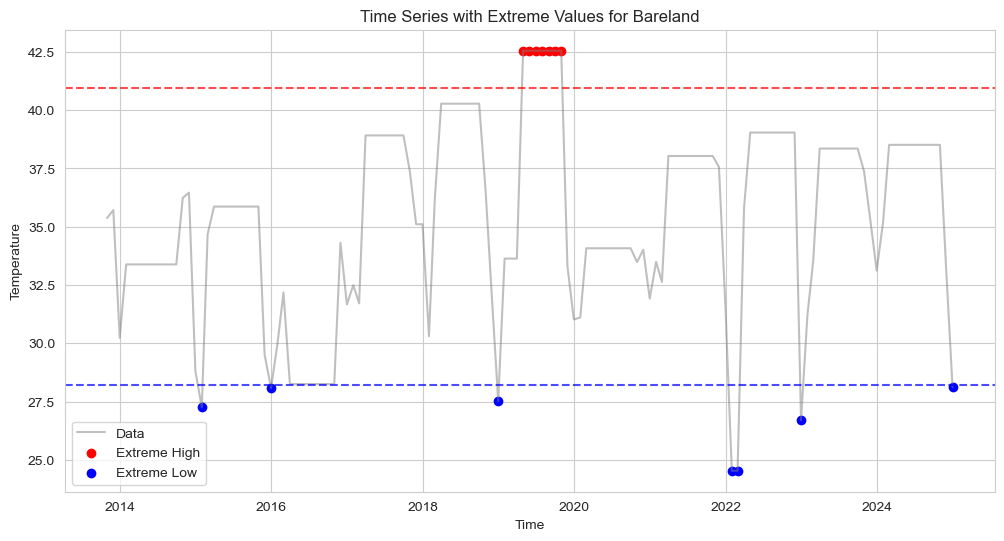

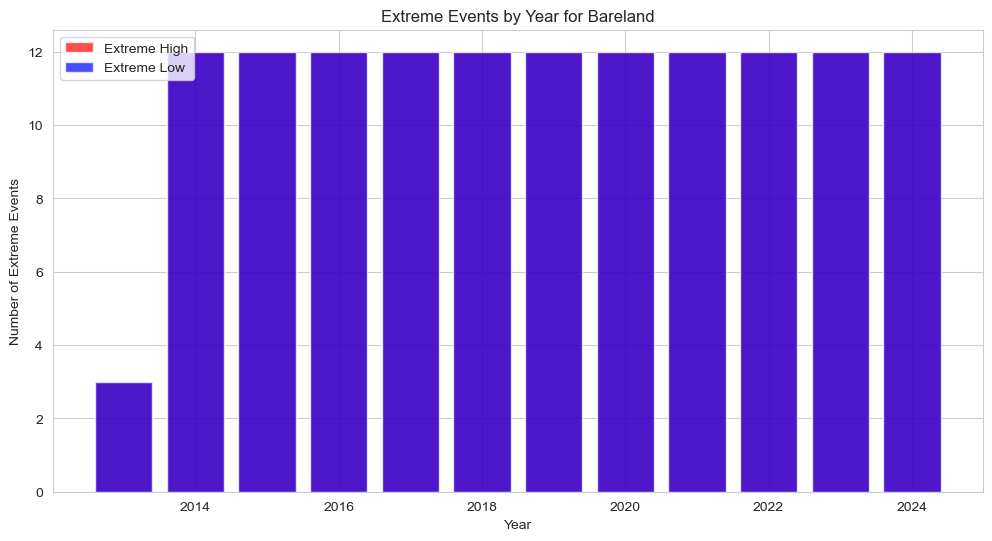

************************************************************
Extreme Value Analysis of Shrub
************************************************************
Extreme Value Analysis
Upper threshold (95th percentile): 39.37
Lower threshold (5th percentile): 27.21
Number of extreme high values: 135
Number of extreme low values: 135


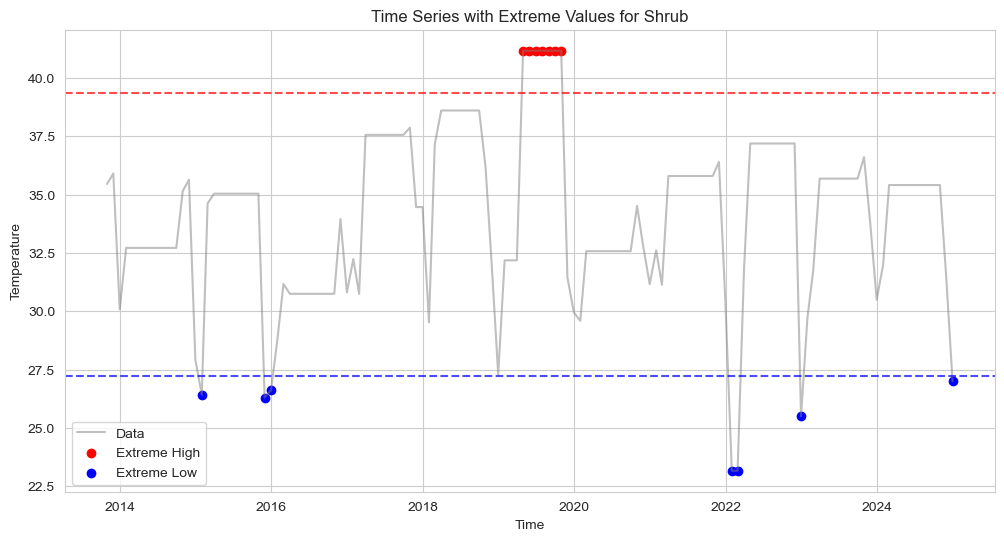

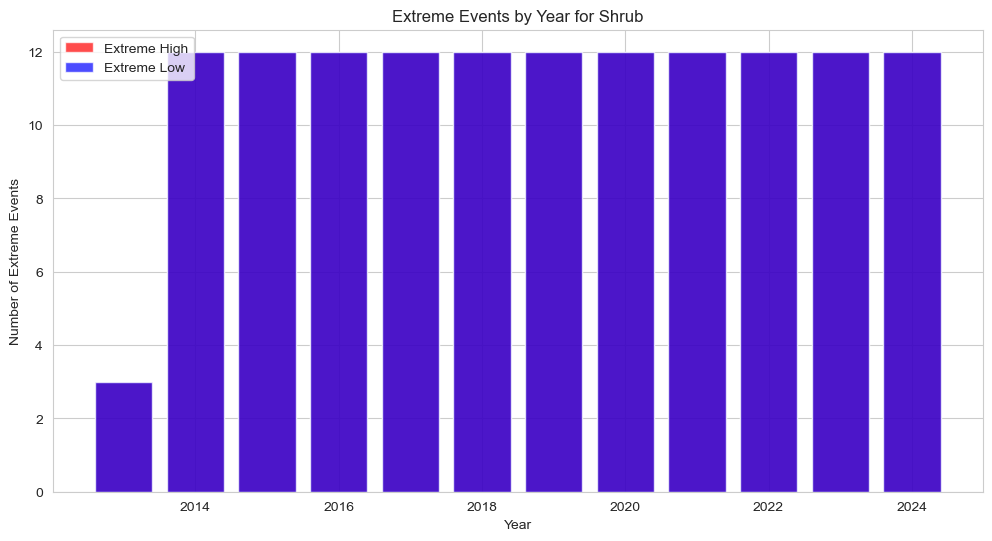

************************************************************
Extreme Value Analysis of Grass
************************************************************
Extreme Value Analysis
Upper threshold (95th percentile): 41.43
Lower threshold (5th percentile): 25.70
Number of extreme high values: 135
Number of extreme low values: 135


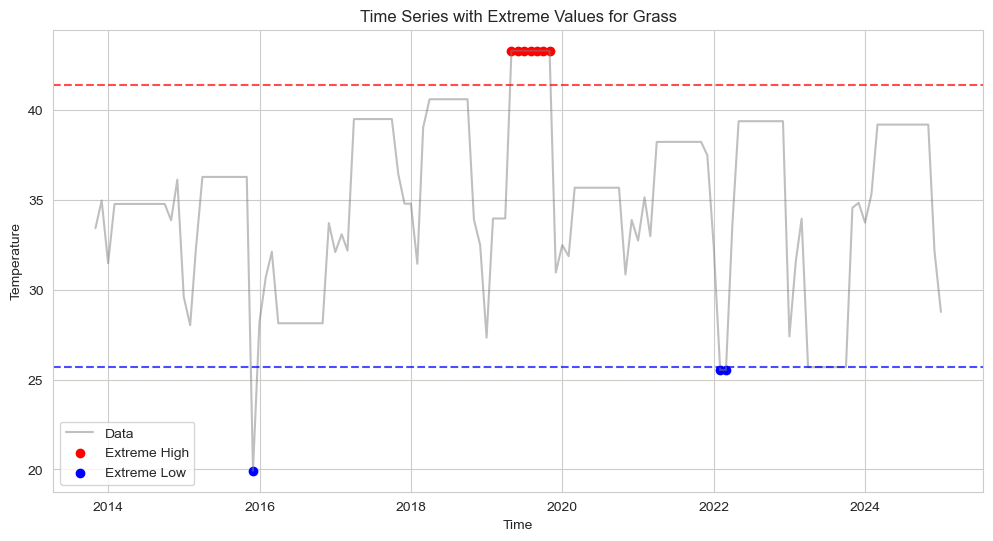

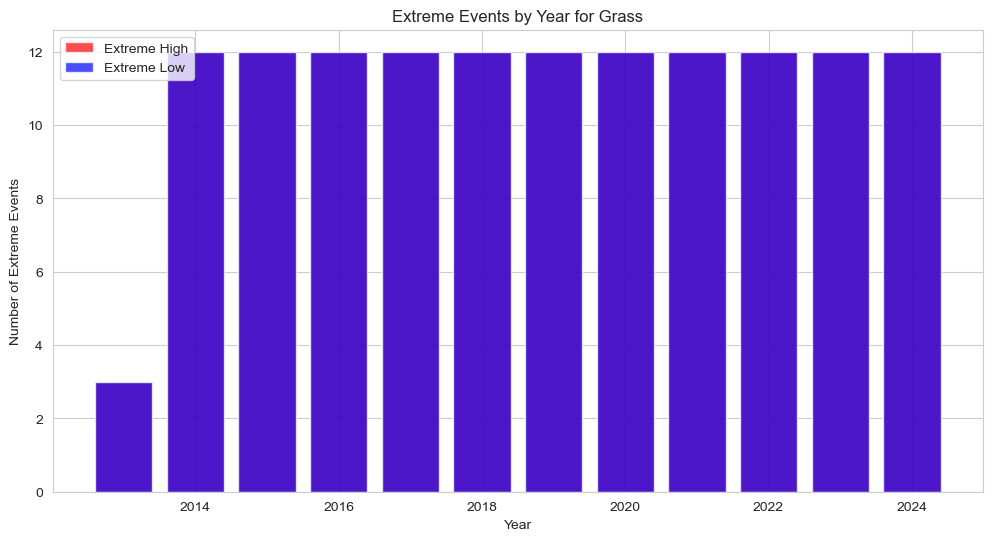

************************************************************
Extreme Value Analysis of Forest
************************************************************
Extreme Value Analysis
Upper threshold (95th percentile): 35.76
Lower threshold (5th percentile): 23.88
Number of extreme high values: 135
Number of extreme low values: 135


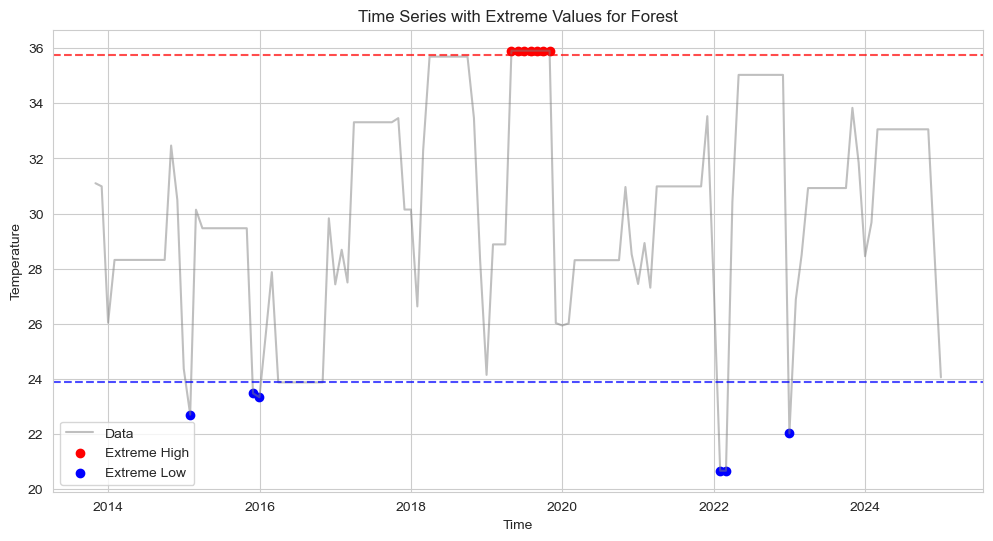

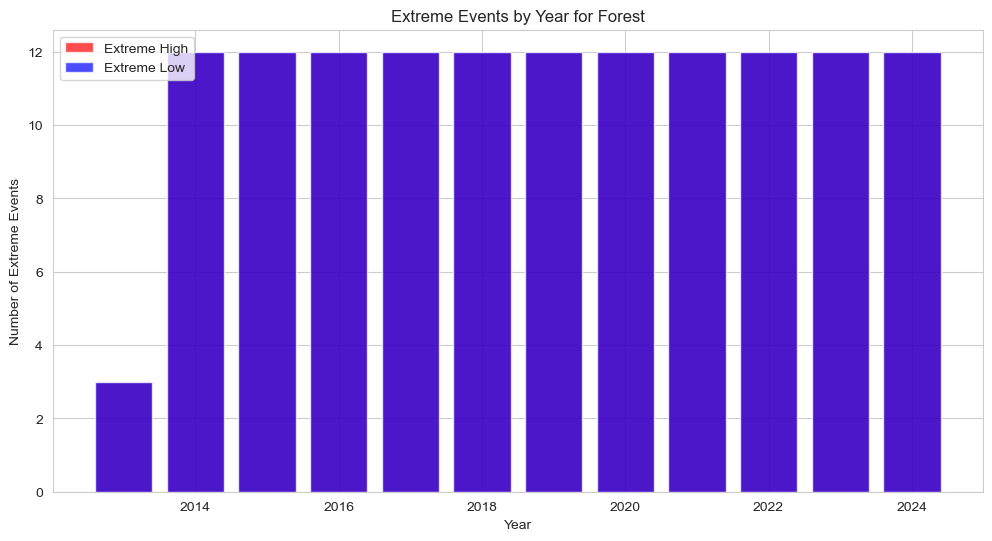

In [175]:
ev_results = {}
for key, df in lst_df.items():
    print("***" * 20)
    print(f'Extreme Value Analysis of {key.capitalize()}')
    print("***" * 20)
    ev_results[key] = extreme_value_analysis(df, key)

### Spatial Pattern Analysis

In [163]:
def spatial_pattern_analysis(data_dict):
    """Analyze spatial patterns in temperature data from multiple locations."""
    print("Spatial Pattern Analysis")
    locations_df = pd.DataFrame(data_dict)
    
    # Calculate correlation matrix
    corr_matrix = locations_df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0.8, vmax=1)
    plt.title('Correlation Between Locations')
    plt.savefig("images/spatial pattern/Correlation.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate and plot average temperature by location
    location_means = locations_df.mean().sort_values()
    
    plt.figure(figsize=(12, 6))
    location_means.plot(kind='bar')
    plt.title('Average Temperature by Location')
    plt.xlabel('Location')
    plt.ylabel('Average Temperature')
    plt.grid(True, axis='y')
    plt.savefig("results/figures/spatial pattern/Average temperature by location.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate and plot temperature variability by location
    location_std = locations_df.std().sort_values()
    
    plt.figure(figsize=(12, 6))
    location_std.plot(kind='bar')
    plt.title('Temperature Variability by Location')
    plt.xlabel('Location')
    plt.ylabel('Standard Deviation')
    plt.grid(True, axis='y')
    plt.savefig("results/figures/spatial pattern/Temperature variability",dpi=300, bbox_inches='tight')
    plt.show()
    
    # Perform PCA if there are enough locations
    if len(data_dict) > 2:
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(locations_df)
        
        # Perform PCA
        pca = PCA()
        pca_result = pca.fit_transform(scaled_data)
        
        # Plot explained variance
        plt.figure(figsize=(10, 6))
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                 np.cumsum(pca.explained_variance_ratio_), 
                 'ro-')
        plt.title('PCA Explained Variance')
        plt.xlabel('Principal Component')
        plt.ylabel('Proportion of Variance Explained')
        plt.grid(True)
        plt.savefig("images/spatial pattern/Explained PCA.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Plot first two principal components
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
        plt.title('First Two Principal Components')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid(True)
        plt.savefig('images/spatial pattern/First Two Principal Components.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Return PCA results
        return {
            'corr_matrix': corr_matrix,
            'location_means': location_means,
            'location_std': location_std,
            'pca': pca,
            'pca_result': pca_result
        }
    
    return {
        'corr_matrix': corr_matrix,
        'location_means': location_means,
        'location_std': location_std
    }

In [68]:
 locations = {
     'Bare Land': df_bare['LST'],
     'Built Up Area': df_bua['LST'],
     'Crop': df_crop['LST'],
     'Forest': df_forest['LST'],
     'Grass': df_grass['LST'],
     'Shrub': df_shrub['LST'],
    }

Spatial Pattern Analysis


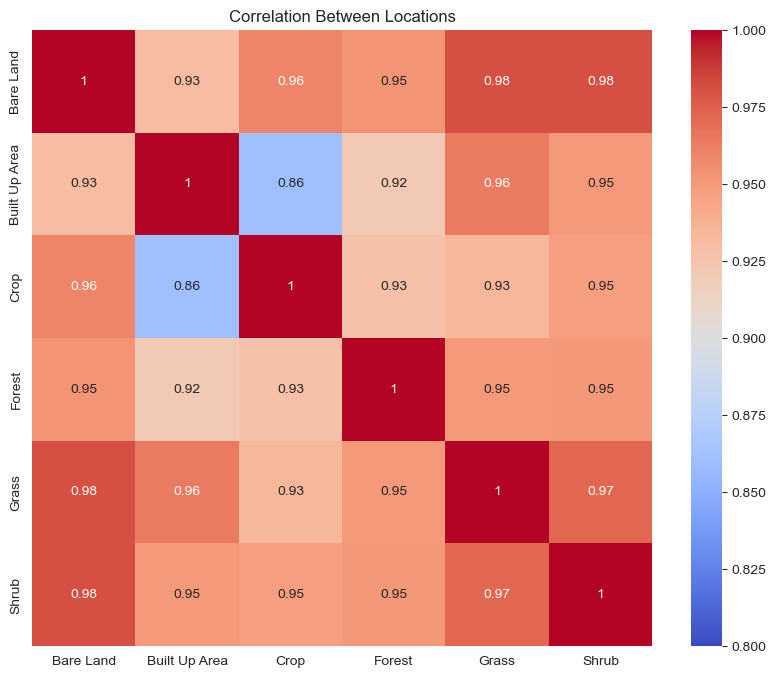

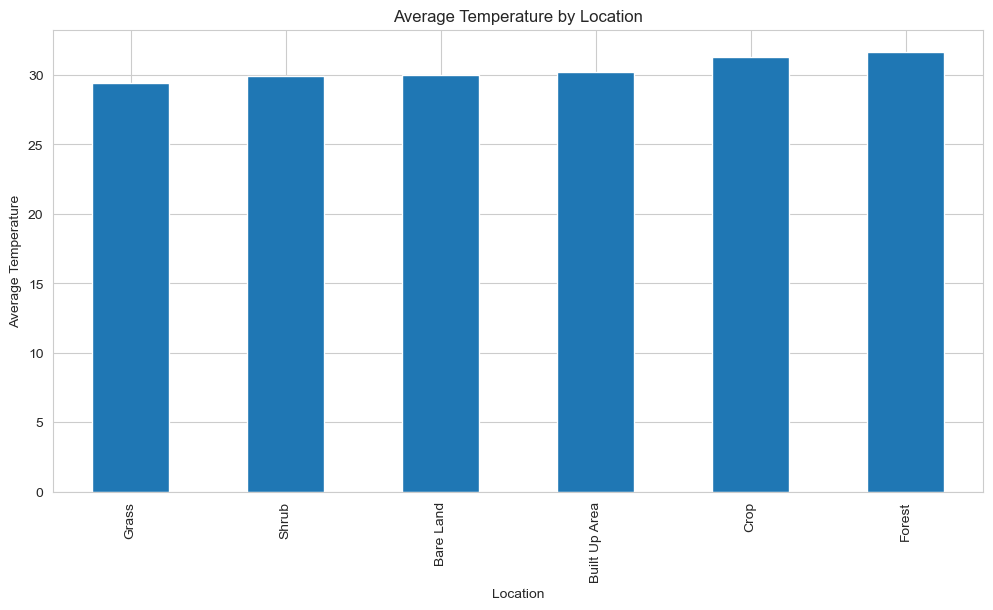

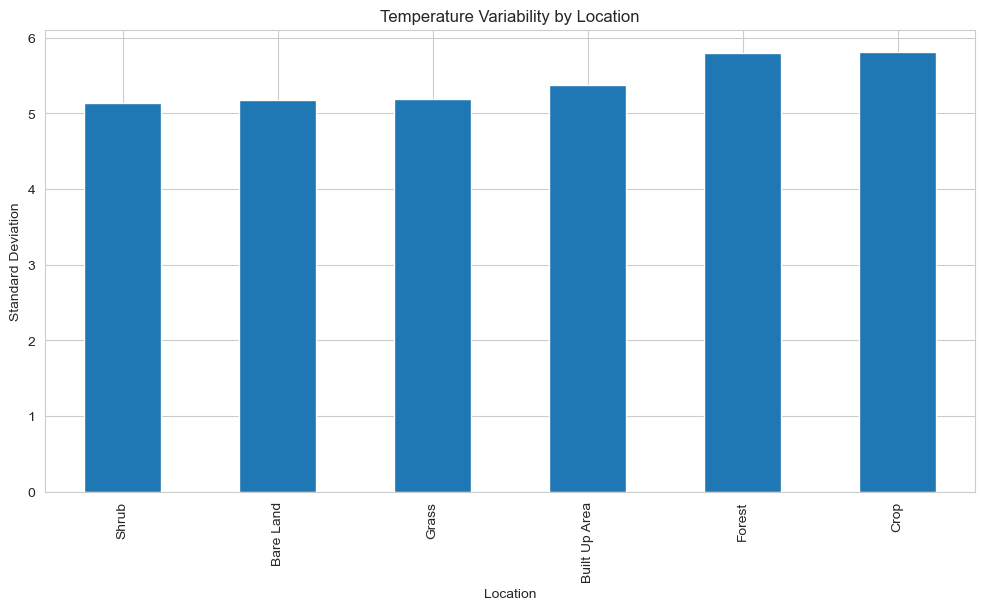

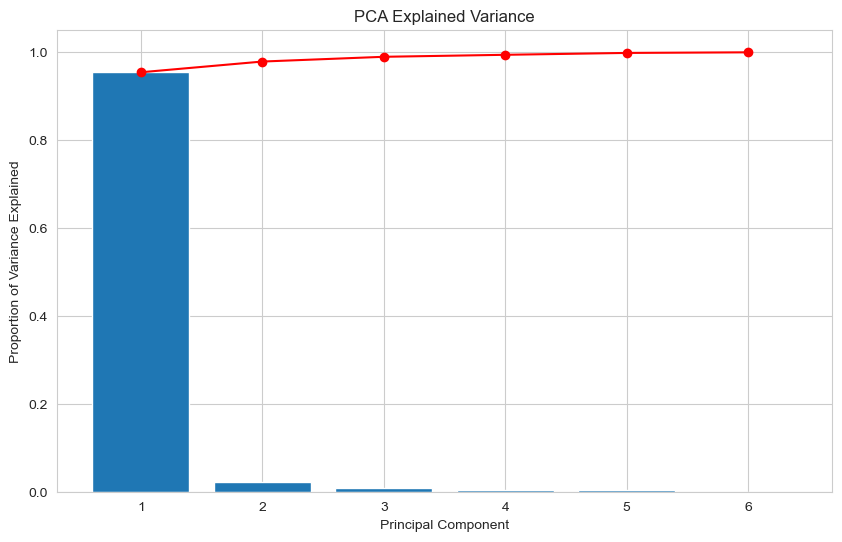

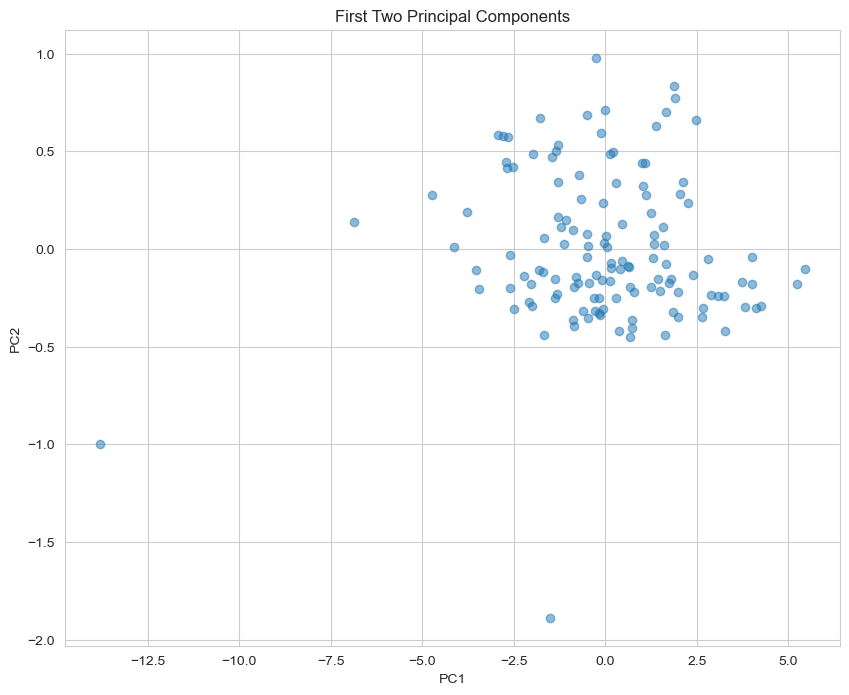

In [69]:
spa = spatial_pattern_analysis(locations)